In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read time series
df = pd.read_csv("interior_temp.csv")

In [3]:
df.drop(columns=["Unnamed: 0", "sensorId", "user"], axis=1, inplace=True)

In [4]:
df.set_index('time_point', inplace=True)

In [5]:
df.index = pd.to_datetime(df.index)

In [6]:
df = df.resample('60min').mean()

In [7]:
df = df.loc['2021-03-01':'2021-06-01']

In [8]:
df = df.fillna(method ='bfill')

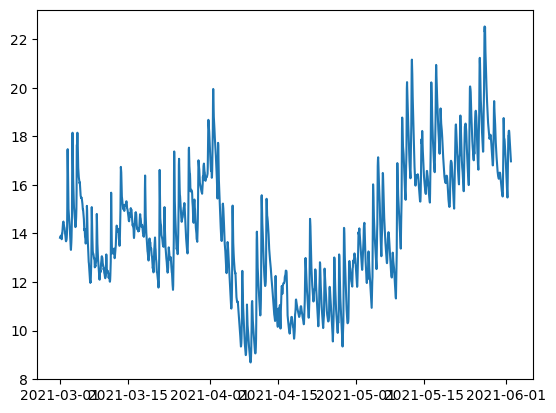

In [9]:
plt.plot(df)

In [10]:
n = len(df.values)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

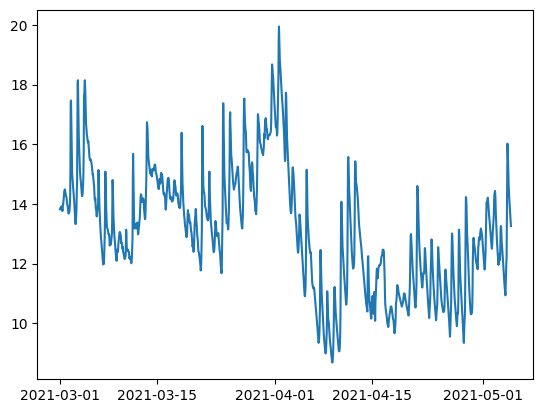

In [11]:
plt.plot(train_df)

In [12]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

In [13]:
min_max_scaler.fit(train_df)

MinMaxScaler()

In [14]:
train_df["scaled"] = min_max_scaler.transform(train_df.values)
val_df["scaled"] = min_max_scaler.transform(val_df.values)
test_df["scaled"] = min_max_scaler.transform(test_df.values)

/home/spirit/Edu/Cyber/cyber_new/venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/tmp/ipykernel_7429/3473310514.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["scaled"] = min_max_scaler.transform(train_df.values)
/home/spirit/Edu/Cyber/cyber_new/venv/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/tmp/ipykernel_7429/3473310514.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [37]:
class ConvertSeries2Matrix:
    
    def __init__(self, n_input: int, n_output: int, step=1) -> None:
        self.n_input = n_input
        self.n_output = n_output
        self.step = step

    def series_to_supervised(self, data, dropnan=True):
        """
        Frame a time series as a supervised learning dataset.
        Arguments:
            data: Sequence of observations as a list or NumPy array.
            n_in: Number of lag observations as input (X).
            n_out: Number of observations as output (y).
            dropnan: Boolean whether or not to drop rows with NaN values.
        Returns:
            Pandas DataFrame of series framed for supervised learning.
        """
        variables = data.columns 
        n_vars = 1 if type(data) is list else data.shape[1]
        
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(self.n_input, 0, -1):
            cols.append(df.shift(i))
            names += [(f'{name}(t-{i})') for name in variables]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, self.n_output):
            cols.append(df.shift(-i))
            if i == 0:
                names += [(f'{name}(t)') for name in variables]
            else:
                names += [(f'{name}(t+{i})') for name in variables]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
            agg.dropna(inplace=True)
        return agg
        

In [38]:
c = ConvertSeries2Matrix(3,2)

In [39]:
data = c.series_to_supervised(train_df)

In [40]:
data

,value(t-3),scaled(t-3),value(t-2),scaled(t-2),value(t-1),scaled(t-1),value(t),scaled(t),value(t+1),scaled(t+1)
time_point,,,,,,,,,,
2021-03-01 03:00:00+00:00,13.822500,0.456056,13.843500,0.457921,13.875000,0.460719,13.864500,0.459786,13.895667,0.462554
2021-03-01 04:00:00+00:00,13.843500,0.457921,13.875000,0.460719,13.864500,0.459786,13.895667,0.462554,13.916333,0.464389
2021-03-01 05:00:00+00:00,13.875000,0.460719,13.864500,0.459786,13.895667,0.462554,13.916333,0.464389,13.912200,0.464022
2021-03-01 06:00:00+00:00,13.864500,0.459786,13.895667,0.462554,13.916333,0.464389,13.912200,0.464022,13.843500,0.457921
2021-03-01 07:00:00+00:00,13.895667,0.462554,13.916333,0.464389,13.912200,0.464022,13.843500,0.457921,13.760333,0.450536
...,...,...,...,...,...,...,...,...,...,...
2021-05-04 20:00:00+00:00,14.676833,0.531925,14.437333,0.510657,14.229000,0.492156,14.062333,0.477355,13.843500,0.457921
2021-05-04 21:00:00+00:00,14.437333,0.510657,14.229000,0.492156,14.062333,0.477355,13.843500,0.457921,13.676833,0.443121
2021-05-04 22:00:00+00:00,14.229000,0.492156,14.062333,0.477355,13.843500,0.457921,13.676833,0.443121,13.499667,0.427387
